# Analysis of Alibaba cloud Trace published in 2017

More information about the trace can be found here: https://github.com/alibaba/clusterdata/tree/master/cluster-trace-v2017

In [1]:
import dask.dataframe as dd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import scipy.stats as sps

# JOB WORKLOADS

## Importing data

In [3]:
column_names_s17 = [
  "create_timestamp",
  "modify_timestamp",
  "job_id",
  "task_id",
  "instance_num",
  "status",
  "plan_cpu",
  "plan_mem"
]

column_types_s17 = {
  column_names_s17[0]: 'int64',
  column_names_s17[1]: 'int64',
  column_names_s17[2]: 'int32',
  column_names_s17[3]: 'int32',
  column_names_s17[4]: 'int64',
  column_names_s17[5]: 'string',
  column_names_s17[6]: 'float32',
  column_names_s17[7]: 'float64',
}

# Here it is expected that the data file (s17_batch_task.csv) is present in the current directory
# If not, update the below sentence accordingly
df_s17 = dd.read_csv('./s17_batch_task.csv', blocksize=25e8, names=column_types_s17, dtype=column_types_s17)

In [4]:
column_names_s18 = [
    "start_timestamp",
    "end_timestamp",
    "job_id",
    "task_id",
    "machineID",
    "status",
    "seq_no",
    "total_seq_no",
    "real_cpu_max",
    "real_cpu_avg",
    "real_mem_max",
    "real_mem_avg",
]

column_types_s18_i = {
    column_names_s18[0]: object,
    column_names_s18[1]: object,
    column_names_s18[2]: object,
    column_names_s18[3]: object,
    column_names_s18[4]: object,
    column_names_s18[5]: object,
    column_names_s18[6]: object,
    column_names_s18[7]: object,
    column_names_s18[8]: object,
    column_names_s18[9]: object,
    column_names_s18[10]: object,
    column_names_s18[11]: object,
}

df_s18_i = dd.read_csv('./s18_batch_instance.csv', blocksize=25e8, names=column_names_s18, dtype=column_types_s18_i)

column_types_s18 = {
    column_names_s18[0]: 'int64',
    column_names_s18[1]: 'int64',
    column_names_s18[2]: 'int32',
    column_names_s18[3]: 'int32',
    column_names_s18[4]: 'int32',
    column_names_s18[5]: object,
    column_names_s18[6]: 'int32',
    column_names_s18[7]: 'int32',
    column_names_s18[8]: 'float32',
    column_names_s18[9]: 'float32',
    column_names_s18[10]: 'float64',
    column_names_s18[11]: 'float64',
}

df_s18 = df_s18_i.fillna(-1).astype(column_types_s18)

In [4]:
# df_s17.shape[0].compute()

# df_s17['job_id'].nunique().compute()

# df_s17.query('job_id == ').compute()

## Numbers in Brief

In [5]:
tasks_per_job = df_s17.groupby('job_id')['task_id'].count()

In [6]:
tasks_per_job_mean = tasks_per_job.mean().compute()
tasks_per_job_max = tasks_per_job.max().compute()
tasks_per_job_min = tasks_per_job.min().compute()

### Tasks per Job

In [7]:
tasks_per_job_mean, tasks_per_job_max, tasks_per_job_min

(6.219828584665277, 156, 1)

In [8]:
# df_s17.query('task_id == 2').compute()

In [9]:
instances_per_task = df_s17.groupby('task_id')['instance_num'].sum()

In [10]:
instances_per_task_mean = instances_per_task.mean().compute()
instances_per_task_max = instances_per_task.max().compute()
instances_per_task_min = instances_per_task.min().compute()

### Instances per Task

In [11]:
instances_per_task_mean, instances_per_task_max, instances_per_task_min

(147.84453713704022, 64486, 1)

In [12]:
instances_per_job = df_s17.groupby('job_id')['instance_num'].sum()

In [13]:
instances_per_job_mean = instances_per_job.mean().compute()
instances_per_job_max = instances_per_job.max().compute()
instances_per_job_min = instances_per_job.min().compute()

## Instances per Job

In [14]:
instances_per_job_mean, instances_per_job_max, instances_per_job_min

(919.5676781715698, 66632, 1)

### Total Jobs in Alibaba 2017 data for job traces

In [15]:
no_of_jobs_in_alibaba_17 = df_s17['job_id'].nunique().compute()
no_of_jobs_in_alibaba_17

12951

In [16]:
total_vms = df_s18['machineID'].replace(-1, np.NaN).nunique().compute()

### Total no of VMs in Alibaba 2017 data for job traces

In [17]:
total_vms

1293

### Job execution time v resource utilization

In [72]:
df_s17.compute()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
0,6459,6524,3,4,15740,Terminated,50.0,0.007957
1,6457,6533,3,5,1,Terminated,50.0,0.004395
2,6036,6046,4,7,393,Waiting,NaN,NaN
3,6036,6046,4,6,452,Waiting,NaN,NaN
4,10719,11332,15,67,1705,Terminated,50.0,0.005736
...,...,...,...,...,...,...,...,...
80548,32996,33043,12935,80454,65,Terminated,50.0,0.009681
80549,32996,33061,12935,80453,69,Terminated,50.0,0.010706
80550,32996,33069,12935,80452,249,Terminated,50.0,0.007962
80551,32996,32999,12935,80457,1,Terminated,50.0,0.004059


In [74]:
df_s18.compute()

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
0,41562,41618,120,686,299,Terminated,1,1,1.50,0.29,-1.000000,-1.000000
1,41561,41619,120,686,1279,Terminated,1,1,0.89,0.28,-1.000000,-1.000000
2,41562,41617,120,686,828,Terminated,1,1,0.94,0.29,-1.000000,-1.000000
3,41561,41617,120,686,95,Terminated,1,1,1.00,0.31,-1.000000,-1.000000
4,41557,41610,120,686,545,Terminated,1,1,1.37,0.29,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
16094651,73512,73514,-1,-1,365,Terminated,1,1,1.00,0.93,0.000813,0.000611
16094652,73512,73514,-1,-1,13,Terminated,1,1,1.00,0.35,0.001098,0.000906
16094653,73512,73518,-1,-1,421,Terminated,1,1,0.95,0.22,0.001512,0.000890
16094654,73512,73518,-1,-1,409,Terminated,1,1,0.93,0.25,0.001439,0.000947


In [47]:
df_s18['status'].value_counts().compute()

Terminated     13707867
Waiting         1268982
Running          835194
Failed           209168
Ready             67618
Interrupted        5827
Name: status, dtype: int64

In [48]:
df_s17['status'].value_counts().compute()

Terminated    67013
Waiting        8847
Running        3567
Failed         1126
Name: status, dtype: Int64

## Execution Time

### Job duration

In [75]:
job_end = df_s18[['end_timestamp', 'job_id']].replace(-1, np.NaN).dropna().groupby('job_id').max().compute()

In [37]:
job_start = df_s17[['job_id', 'create_timestamp']].replace(-1, np.NaN).groupby('job_id').min().compute()
job_end_2 = df_s17[['job_id', 'modify_timestamp']].replace(-1, np.NaN).groupby('job_id').max().compute()

## modify timestamps > end timestamps 

Modify timestamps in the `batch_tasks` seems to have the values greater than or equal values compared to the `end_timestamp` values

the difference can be seen in the below output where the `job_end_2` from `batch_tasks` have 12893 values greater than or equal to 

In [76]:
(job_end['end_timestamp'].astype('int64') <= job_end_2['modify_timestamp']).value_counts()

True     12893
False       58
dtype: int64

In [38]:
exec_each_job = dd.from_array(job_end_2['modify_timestamp'] - job_start['create_timestamp'], columns={"execution_time": 'int64'}).compute()

<AxesSubplot:xlabel='execution_time', ylabel='Proportion'>

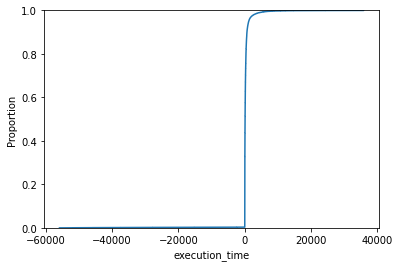

In [33]:
sns.ecdfplot(data=exec_each_job, x="execution_time")

> Some values in the `batch_tasks` modify_timestamp are 0 but the create timestamps are in 57000 which lead to closely -60000 values being shown in the CDF. So below is the plot where negatives values are cutoff

## CDF of Job Duration

<AxesSubplot:xlabel='execution_time', ylabel='Proportion'>

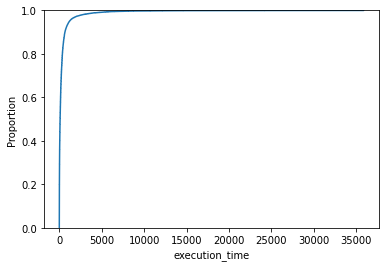

In [34]:
sns.ecdfplot(data=exec_each_job[exec_each_job['execution_time'] >= 0], x="execution_time")

In [11]:
# exec_each_job['execution_time'] = exec_each_job['execution_time'].apply(np.log10)

[Text(0.5, 0, 'Execution Time(sec)'), Text(0, 0.5, 'Propotion of Jobs'), None]

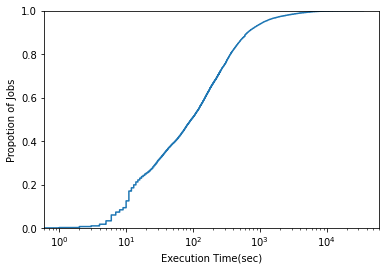

In [37]:
j_e_p = sns.ecdfplot(data=exec_each_job[exec_each_job['execution_time'] >= 0], x="execution_time")
j_e_p.set(xlabel="Execution Time(sec)", ylabel="Propotion of Jobs", xscale="log")

> Although there are `12893` jobs with end timestamp from batch_tasks being more accurate than batch_instances, we got 12906 with non negative execution times. This maybe because of the 0.1% of `12893` (~13 records) with negative timestamps which match the exact calculation

In [13]:
len(exec_each_job[exec_each_job['execution_time'] >= 0])

12906

In [16]:
job_start.min(), job_end_2.max()

(create_timestamp   -1078
 dtype: int64,
 modify_timestamp    61668
 dtype: int64)

In [19]:
df_s17['instance_num'].min().compute(), df_s17['instance_num'].max().compute()

(1, 64486)

In [49]:
tasks_each_job = df_s17[['job_id', 'task_id']].groupby('job_id').count().compute()

In [50]:
tasks_each_job = tasks_each_job.rename(columns = {'task_id': 'tasks_num'})

In [16]:
tasks_each_job

,tasks_num
job_id,
1,1
2,2
3,2
4,2
5,2
...,...
12947,6
12948,6
12949,6


In [ ]:
# sns.scatterplot(data=tasks_each_job, )

In [40]:
exec_e_j_c = exec_each_job[exec_each_job['execution_time'] >= 0]

In [41]:
exec_e_j_c.quantile(0.9)/60 # 90% of jobs take less than 11.05min execution time

execution_time    11.058333
Name: 0.9, dtype: float64

In [52]:
exec_v_tasks_each_job = dd.concat([exec_e_j_c, tasks_each_job], axis=1, join='inner').compute()

**Execution time v num of Tasks**

<AxesSubplot:xlabel='execution_time', ylabel='tasks_num'>

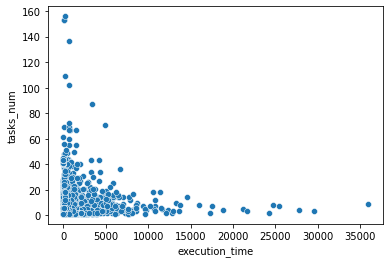

In [55]:
sns.scatterplot(data=exec_v_tasks_each_job, x="execution_time", y="tasks_num")

[None]

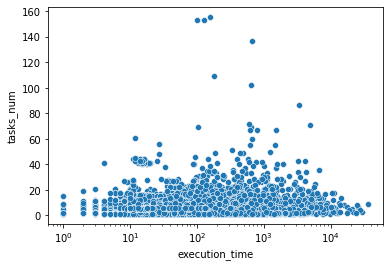

In [54]:
e_v_t = sns.scatterplot(data=exec_v_tasks_each_job, x="execution_time", y="tasks_num")
e_v_t.set(xscale="log")

In [39]:
instances_each_job = df_s17[['job_id', 'instance_num']].groupby('job_id').sum().compute()

In [40]:
exec_v_inst_each_job = dd.concat([exec_each_job[exec_each_job['execution_time'] >= 0], instances_each_job], axis=1, join='inner')
# exec_v_inst_each_job = exec_v_inst_each_job.compute()

<AxesSubplot:xlabel='execution_time', ylabel='instance_num'>

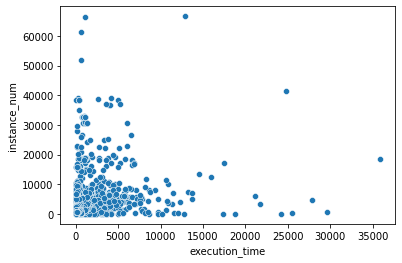

In [42]:
sns.scatterplot(data=exec_v_inst_each_job, x="execution_time", y="instance_num")

[None]

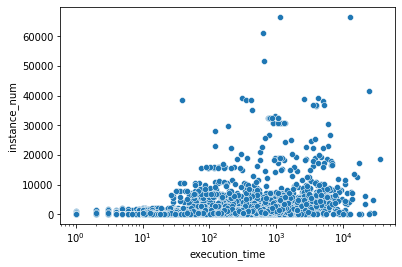

In [43]:
e_v_i = sns.scatterplot(data=exec_v_inst_each_job, x="execution_time", y="instance_num")
e_v_i.set(xscale="log")

**Correlation between num of tasks and execution time**

In [21]:
exec_v_tasks_each_job['tasks_num'].corr(exec_v_tasks_each_job['execution_time'])

0.054214873604556915

In [13]:
task_start = df_s17[['task_id', 'create_timestamp']].replace(-1, np.NaN).groupby('task_id').min()
task_end = df_s17[['task_id', 'modify_timestamp']].replace(-1, np.NaN).groupby('task_id').max()

# task_exec = task_end['modify_timestamp'] - task_start['create_timestamp']

In [21]:
task_exec = task_end['modify_timestamp'] - task_start['create_timestamp']

In [22]:
task_exec = dd.from_array(task_exec, columns={"execution_time": 'int64'})
task_exec = task_exec[task_exec['execution_time'] >= 0]

<AxesSubplot:xlabel='execution_time', ylabel='Proportion'>

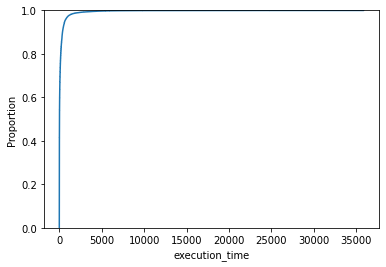

In [23]:
sns.ecdfplot(data=task_exec, x='execution_time')

[Text(0, 0.5, 'Propotion of tasks'), Text(0.5, 0, 'Execution Time(sec)'), None]

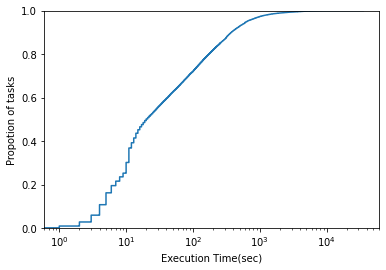

In [38]:
# task_exec['execution_time'] = task_exec['execution_time'].apply(np.log10, meta=('execution_time', 'float32'))
t_e_p = sns.ecdfplot(data=task_exec, x='execution_time')
t_e_p.set(ylabel="Propotion of tasks", xlabel="Execution Time(sec)", xscale="log")

In [29]:
task_exec.shape[0].compute()

80345

In [30]:
df_s17.shape[0].compute()

80553

In [35]:
task_exec.quantile(0.9).compute()/60 # 90% of tasks take less than 6.5min execution time

execution_time    6.5
Name: 0.9, dtype: float64

In [42]:
exec_each_job

,execution_time
job_id,
1,184
2,94
3,76
4,10
5,317
...,...
12947,42
12948,47
12949,129


**sizes**

In [59]:
df_s17.max().compute()

create_timestamp       60181
modify_timestamp       61668
job_id                 12951
task_id                80553
instance_num           64486
status               Waiting
plan_cpu               800.0
plan_mem            0.127332
dtype: object

In [68]:
df_s17.min().compute()

create_timestamp       -1078
modify_timestamp        -843
job_id                     1
task_id                    1
instance_num               1
status                Failed
plan_cpu                40.0
plan_mem            0.002754
dtype: object

In [69]:
df_s18.max().compute()

start_timestamp       86342
end_timestamp         86342
job_id                12951
task_id               80553
machineID              1313
status              Waiting
seq_no                   10
total_seq_no             10
real_cpu_max           32.0
real_cpu_avg           4.44
real_mem_max        0.99839
real_mem_avg       0.163896
dtype: object

In [70]:
df_s18.min().compute()

start_timestamp     -1074
end_timestamp        -845
job_id                 -1
task_id                -1
machineID              -1
status             Failed
seq_no                  1
total_seq_no            1
real_cpu_max         -1.0
real_cpu_avg         -1.0
real_mem_max         -1.0
real_mem_avg         -1.0
dtype: object

The correlation is low and close to zero. So we can conclude that number of tasks in a job doesnt impact the execution time of the jobs

### TODO

* [x] check if starting timestamps for all task instances in the s_18 data are same - (they are not in case of samples like job_id == 23)
* [x] find the sizes of the maximun values in each column to assign the datatypes ()
* [x] Find out the timestamp unit - (it is in seconds)

## Resource Demand and usage

### Resource planned for each job

In [5]:
plan_res_job = df_s17[['job_id', 'plan_cpu', 'plan_mem']].dropna().groupby('job_id').mean()

In [6]:
plan_res_job

,plan_cpu,plan_mem
npartitions=1,,
,float64,float64
,...,...


<AxesSubplot:xlabel='plan_cpu', ylabel='Proportion'>

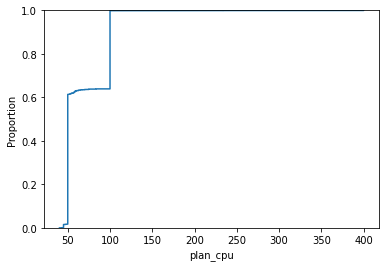

In [7]:
sns.ecdfplot(data=plan_res_job, x='plan_cpu' )

<AxesSubplot:xlabel='plan_mem', ylabel='Proportion'>

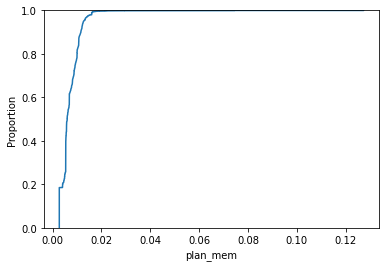

In [8]:
sns.ecdfplot(data=plan_res_job, x='plan_mem' )

### Resource Usage for each job

In [41]:
usage_res_job = df_s18[['job_id', 'real_cpu_avg', 'real_mem_avg']].replace(-1, np.NaN).dropna().groupby('job_id').mean()

<AxesSubplot:xlabel='real_cpu_avg', ylabel='Proportion'>

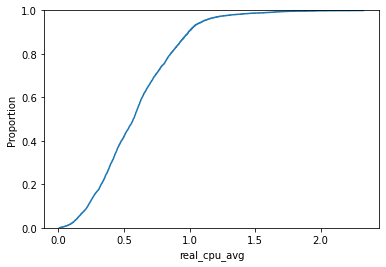

In [12]:
sns.ecdfplot(data=usage_res_job, x='real_cpu_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='Proportion'>

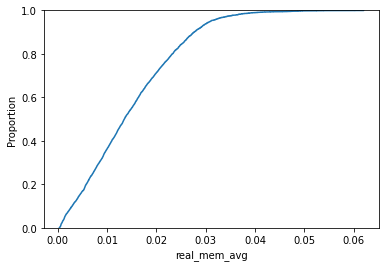

In [13]:
sns.ecdfplot(data=usage_res_job, x='real_mem_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='Count'>

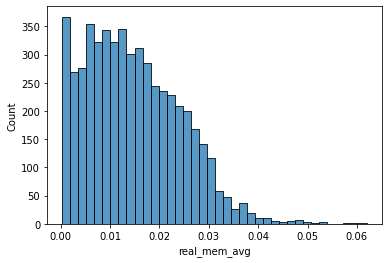

In [14]:
sns.histplot(data=usage_res_job, x='real_mem_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='real_cpu_avg'>

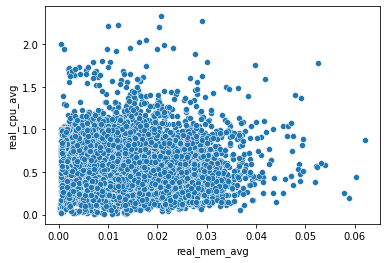

In [7]:
sns.scatterplot(data=usage_res_job, x='real_mem_avg', y='real_cpu_avg')

The correlation is very low implying that the cpu and memory usage are not correlated

This could mean that the workloads are maybe either compute intensive or memory intensive

In [42]:
usage_res_job_c = usage_res_job.compute()
usage_res_job_c['real_mem_avg'].corr(usage_res_job_c['real_cpu_avg'])

-0.033302772777511036

### Resource Demand for each task

In [13]:
plan_res_t = df_s17[['task_id', 'plan_cpu', 'plan_mem']].dropna().groupby('task_id').mean()

<AxesSubplot:xlabel='plan_cpu', ylabel='Proportion'>

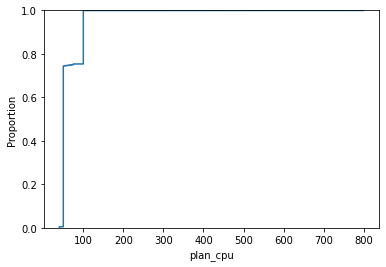

In [14]:
sns.ecdfplot(data=plan_res_t, x='plan_cpu' )

<AxesSubplot:xlabel='plan_mem', ylabel='Proportion'>

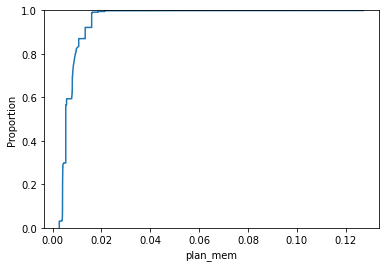

In [15]:
sns.ecdfplot(data=plan_res_t, x='plan_mem' )

### Resource Usage for each task

In [46]:
usage_res_t = df_s18[['task_id', 'real_cpu_avg', 'real_mem_avg']].replace(-1, np.NaN).dropna().groupby('task_id').mean()

<AxesSubplot:xlabel='real_cpu_avg', ylabel='Proportion'>

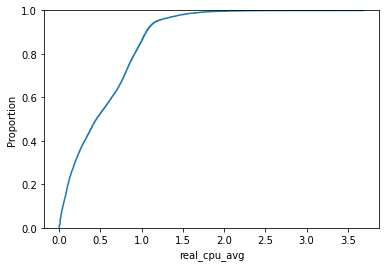

In [18]:
sns.ecdfplot(data=usage_res_t, x='real_cpu_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='Proportion'>

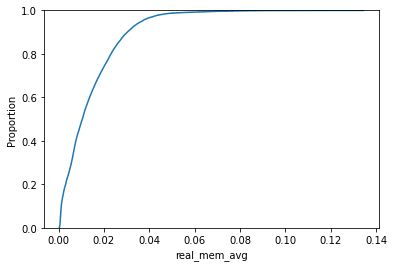

In [19]:
sns.ecdfplot(data=usage_res_t, x='real_mem_avg' )

In [5]:
usage_res_i = df_s18[['real_cpu_avg', 'real_mem_avg']].replace(-1, np.NaN).dropna()

<AxesSubplot:xlabel='real_mem_avg', ylabel='Proportion'>

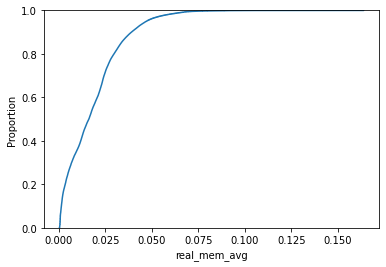

In [6]:
sns.ecdfplot(data=usage_res_i, x='real_mem_avg' )

<AxesSubplot:xlabel='real_cpu_avg', ylabel='Proportion'>

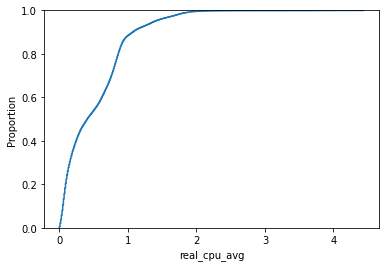

In [7]:
sns.ecdfplot(data=usage_res_i, x='real_cpu_avg' )

In [43]:
exec_each_job

,execution_time
job_id,
1,184
2,94
3,76
4,10
5,317
...,...
12947,42
12948,47
12949,129


In [43]:
# usage_res_job_c
exec_usage_res_job = dd.concat([exec_e_j_c, usage_res_job_c], axis=1, join='inner').compute()

<AxesSubplot:xlabel='execution_time', ylabel='real_cpu_avg'>

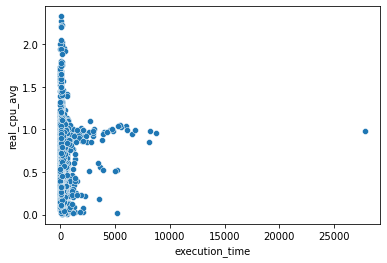

In [54]:
sns.scatterplot(data=exec_usage_res_job, x='execution_time', y='real_cpu_avg')

[Text(0.5, 0, 'Execution Time for job(Sec)'),
 Text(0, 0.5, 'Avg Cpu utilization'),
 None]

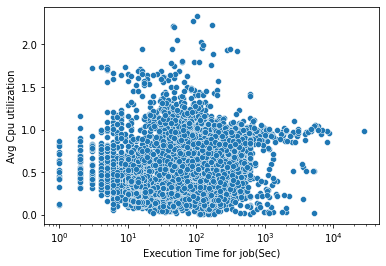

In [44]:
e_v_c = sns.scatterplot(data=exec_usage_res_job, x='execution_time', y='real_cpu_avg')
e_v_c.set(xlabel="Execution Time for job(Sec)", ylabel="Avg Cpu utilization", xscale="log")

<AxesSubplot:xlabel='execution_time', ylabel='real_mem_avg'>

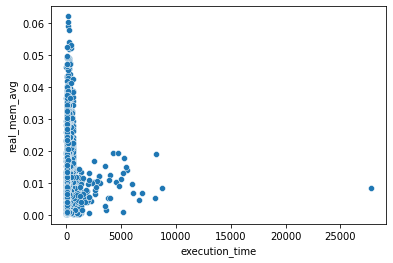

In [55]:
sns.scatterplot(data=exec_usage_res_job, x='execution_time', y='real_mem_avg')

[Text(0.5, 0, 'Execution Time for job(Sec)'),
 Text(0, 0.5, 'Avg Mem utilization'),
 None]

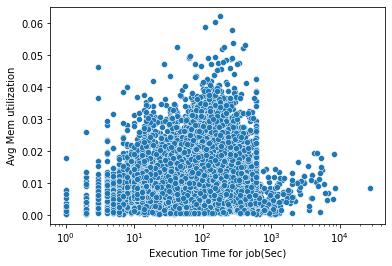

In [45]:
e_v_m = sns.scatterplot(data=exec_usage_res_job, x='execution_time', y='real_mem_avg')
e_v_m.set(xlabel="Execution Time for job(Sec)", ylabel="Avg Mem utilization", xscale="log")

In [56]:
exec_usage_res_job['real_mem_avg'].corr(exec_usage_res_job['execution_time'])

-0.04679775160704231

In [57]:
exec_usage_res_job['real_cpu_avg'].corr(exec_usage_res_job['execution_time'])

0.09172531408454146

## Job Distribution

In [5]:
job_each_m = df_s18[['machineID', 'job_id']].replace(-1, np.NaN).dropna().groupby('machineID')['job_id'].nunique().compute()

[Text(0.5, 0, 'Jobs per Machine(in 12hrs)'), Text(0, 0.5, 'Frequency Count')]

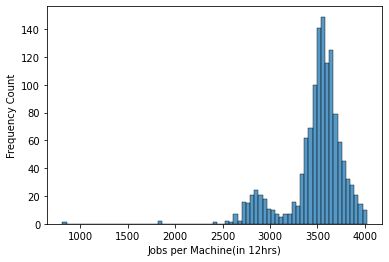

In [7]:
j_e_m = sns.histplot(data=job_each_m)
j_e_m.set(xlabel="Jobs per Machine(in 12hrs)", ylabel="Frequency Count")

[Text(0.5, 0, 'Jobs per Machine(in 12hrs)'), Text(0, 0.5, 'Frequency Count')]

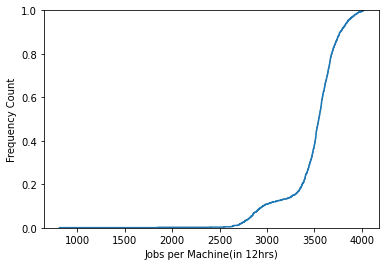

In [8]:
j_e_m = sns.ecdfplot(data=job_each_m)
j_e_m.set(xlabel="Jobs per Machine(in 12hrs)", ylabel="Frequency Count")

In [19]:
sps.percentileofscore(job_each_m, 4000) - sps.percentileofscore(job_each_m, 3000)

88.70843000773395

In [20]:
100 - sps.percentileofscore(job_each_m, 3000) # 89% of machines have more than 3,000 jobs running in 12hrs 

89.1724671307038

In [9]:
job_each_m.quantile(0.2) # need to think of this analysis.

3373.0

In [10]:
job_each_m.quantile(0.9) # need to think of this analysis.

3774.0

In [8]:
m_each_j = df_s18[['machineID', 'job_id']].replace(-1, np.NaN).groupby('job_id')['machineID'].nunique().compute()

In [12]:
m_each_j[m_each_j > 0]

job_id
1.0         203
2.0        1291
3.0        1291
5.0         700
6.0           2
           ... 
12946.0     133
12947.0     116
12948.0     498
12949.0     328
12951.0     424
Name: machineID, Length: 12014, dtype: int64

[Text(0.5, 0, 'machine count per job')]

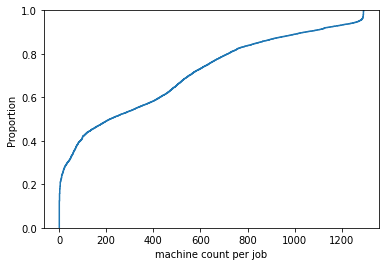

In [34]:
mej = sns.ecdfplot(data=m_each_j[m_each_j > 0])
mej.set(xlabel="machine count per job")

In [35]:
m_each_j[m_each_j > 0].quantile(0.4)

91.0

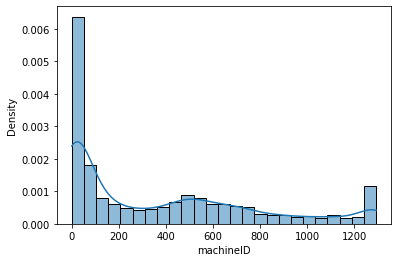

In [32]:
mej = sns.histplot(data=m_each_j[m_each_j > 0], kde=True, stat='density')

In [23]:
df_s18[['job_id', 'machineID']].query("job_id == 4").compute()

,job_id,machineID
13606027,4,-1
13606028,4,-1
13606029,4,-1
13606030,4,-1
13606031,4,-1
...,...,...
13606867,4,-1
13606868,4,-1
13606869,4,-1
13606870,4,-1


In [75]:
m_each_j

,machineID
job_id,
1.0,283
2.0,15741
3.0,15741
5.0,845
6.0,2
...,...
12946.0,135
12947.0,135
12948.0,516


[None]

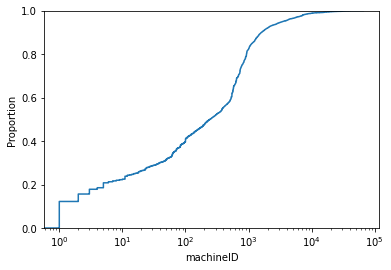

In [78]:
m_e_j = sns.ecdfplot(m_each_j, x='machineID')
m_e_j.set(xscale="log")

In [11]:
m_each_j.mean(), m_each_j.median() # average number of machines used per job over 12hours

(machineID    930.711004
 dtype: float64,
 machineID    247.0
 dtype: float64)

**total machine count**

In [8]:
df_s18['machineID'].replace(-1, np.NaN).dropna().nunique().compute()

1293

[None]

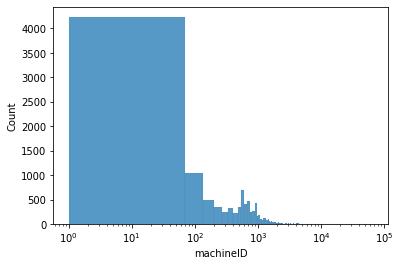

In [13]:
m_e_j = sns.histplot(m_each_j, x='machineID')
m_e_j.set(xscale="log")

In [14]:
m_each_j.quantile(0.9) # need to think of this analysis.

machineID    1617.1
Name: 0.9, dtype: float64

In [16]:
m_each_j.quantile(0.5) # need to think of this analysis.

machineID    247.0
Name: 0.5, dtype: float64

**Waiting Time**

In [ ]:
df_s18[['job_id', 'status']].replace(-1, np.NaN).dropna().groupby('job_id')['status'].nunique().compute()

In [24]:
status_df = df_s18['status'].replace(-1, np.NaN).dropna()
# status_df.compute()

In [25]:
status_df = dd.from_array(status_df, columns={"status": 'category'})


KeyboardInterrupt



## sandbox

In [18]:
df_s17.head()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
0,6459,6524,3,4,15740,Terminated,50.0,0.007957
1,6457,6533,3,5,1,Terminated,50.0,0.004395
2,6036,6046,4,7,393,Waiting,NaN,NaN
3,6036,6046,4,6,452,Waiting,NaN,NaN
4,10719,11332,15,67,1705,Terminated,50.0,0.005736


In [22]:
df_s17.query('status == "Running"').compute().head()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
33,16341,16391,28,151,61,Running,50.0,0.007936
35,16341,16391,28,152,23,Running,50.0,0.013356
36,16341,16391,28,154,261,Running,50.0,0.008205
139,24775,24927,61,438,319,Running,50.0,0.013356
140,24775,24927,61,446,3,Running,50.0,0.007952


In [23]:
df_s17.query('job_id == 28').compute()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
33,16341,16391,28,151,61,Running,50.0,0.007936
34,16341,16391,28,153,407,Failed,50.0,0.016007
35,16341,16391,28,152,23,Running,50.0,0.013356
36,16341,16391,28,154,261,Running,50.0,0.008205


In [4]:
j28_t_151 = df_s18.query('job_id == 28 & task_id == 151').compute()
j28_t_151

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
10757599,16348,16391,28,151,742,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757600,16348,16391,28,151,786,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757601,16348,16391,28,151,302,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757602,16348,16391,28,151,159,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757603,16348,16391,28,151,149,Running,1,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10757679,16348,16391,28,151,572,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757680,16348,16391,28,151,612,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757681,16348,16391,28,151,1095,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757682,16348,16391,28,151,819,Running,1,1,-1.0,-1.0,-1.0,-1.0


In [ ]:
# df_s18.groupby('job_id')['real_cpu_avg'].mean()

df_cdf_mem = df_s18.replace(-1, np.NaN).dropna().groupby('job_id')['real_mem_avg'].mean().compute()

In [7]:
j28_t_151.replace(-1, np.NaN)['real_mem_avg'].mean()

nan

In [11]:
non_nan = df_s18.replace(-1, np.NaN).dropna().head()

In [12]:
non_nan

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
4214,16218.0,16248.0,239.0,1328.0,1214.0,Terminated,1,1,0.94,0.04,0.007589,0.007346
4215,16218.0,16248.0,239.0,1328.0,348.0,Terminated,1,1,0.87,0.04,0.007527,0.007284
4216,16218.0,16248.0,239.0,1328.0,736.0,Terminated,1,1,1.00,0.04,0.008397,0.008164
4217,16218.0,16247.0,239.0,1328.0,745.0,Terminated,1,1,0.86,0.03,0.008589,0.008392
4218,16218.0,16248.0,239.0,1328.0,1100.0,Terminated,1,1,0.93,0.04,0.009562,0.009329


In [14]:
test = dd.concat([non_nan, j28_t_151])

In [22]:
test.compute().replace(-1, np.NaN).dropna().groupby('job_id')[['real_mem_avg', 'real_cpu_avg']].mean()

,real_mem_avg,real_cpu_avg
job_id,,
239.0,0.008103,0.038


In [ ]:
mem_and_cpu_per_job = df_s18.replace(-1, np.NaN).dropna().groupby('job_id').[['real_mem_avg', 'real_cpu_avg']].mean()

In [4]:
failed_28 = df_s18.query('job_id == 28 & task_id == 153').compute()

In [7]:
failed_28.query('status == "Failed"')

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
10757571,16349,0,28,153,725,Failed,1,1,-1.0,-1.0,-1.0,-1.0


In [9]:
failed_28['end_timestamp'].max()

16391

In [10]:
failed_28['start_timestamp'].min()

16349

In [13]:
j_28 = df_s18.query('job_id == 28').compute()

In [14]:
j_28_min_exec, j_28_max_exec = j_28['start_timestamp'].min(), j_28['end_timestamp'].max()

In [15]:
j_28_min_exec, j_28_max_exec

(16348, 16391)

In [16]:
j_28

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
10757402,16349,16391,28,153,290,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757403,16349,16391,28,153,702,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757404,16349,16391,28,153,1215,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757405,16349,16391,28,153,1131,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757406,16349,16391,28,153,959,Running,1,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10758149,16348,16391,28,154,693,Running,1,1,-1.0,-1.0,-1.0,-1.0
10758150,16348,16391,28,154,884,Running,1,1,-1.0,-1.0,-1.0,-1.0
10758151,16348,16391,28,154,831,Running,1,1,-1.0,-1.0,-1.0,-1.0
10758152,16348,16391,28,154,32,Running,1,1,-1.0,-1.0,-1.0,-1.0


In [9]:
df_s17['plan_mem'].max().compute()

0.1273315559236922

In [66]:
a = df_s18[['start_timestamp', 'end_timestamp', 'job_id', 'task_id']].query('job_id == 23')
a

,start_timestamp,end_timestamp,job_id,task_id
npartitions=1,,,,
,int64,int64,int32,int32
,...,...,...,...


In [67]:
a.compute()

,start_timestamp,end_timestamp,job_id,task_id
13949957,14550,14566,23,107
13949958,14549,14565,23,107
13949959,14548,14563,23,107
13949960,14548,14563,23,107
13949961,14548,14562,23,107
...,...,...,...,...
13951987,14230,14305,23,112
13951988,14230,14290,23,112
13951989,14230,14282,23,112
13951990,14230,14280,23,112
